In [1]:
# Подключение к Гугл Диску
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Tensorflow обновился до 2.0, здесь присходит откат на версию 1.14
!pip install tensorflow==1.14.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 109.2MB 89kB/s 
     |████████████████████████████████| 3.2MB 36.9MB/s 
     |████████████████████████████████| 491kB 61.2MB/s 
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0


In [3]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

import math
import seaborn as sns
import umap
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
from random import shuffle
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Input


import sys
import random
import warnings
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [0]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [0]:
TRAIN_DIR = '/content/drive/My Drive/mri/data/train/'
TEST_DIR = '/content/drive/My Drive/mri/data/test/'
VAL_DIR = '/content/drive/My Drive/mri/data/val/'
IMG_SIZE = (224,224)

In [6]:
# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

  0%|          | 0/4 [00:00<?, ?it/s]

3010 images loaded from /content/drive/My Drive/mri/data/train/ directory.


  0%|          | 0/4 [00:00<?, ?it/s]

379 images loaded from /content/drive/My Drive/mri/data/test/ directory.


100%|██████████| 4/4 [01:36<00:00, 24.03s/it]

375 images loaded from /content/drive/My Drive/mri/data/val/ directory.


In [0]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()
## plot_samples(X_train, y_train, labels, 30)

In [0]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

X_train_prep = preprocess_imgs(set_name=X_train, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)

In [0]:
#plot_samples(X_train_prep, y_train, labels, 30)

In [0]:
np.savez("/content/drive/My Drive/mri/npz/x_train_prep", X_train_prep)
np.savez("/content/drive/My Drive/mri/npz/y_train", y_train)

np.savez("/content/drive/My Drive/mri/npz/x_test_prep", X_test_prep)
np.savez("/content/drive/My Drive/mri/npz/y_test", y_test)

np.savez("/content/drive/My Drive/mri/npz/x_val_prep", X_val_prep)
np.savez("/content/drive/My Drive/mri/npz/y_val", y_val)

In [34]:
TRAIN_DIR = '/content/drive/My Drive/mri/data/train/'
VAL_DIR = '/content/drive/My Drive/mri/data/val/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='categorical',
    seed=RANDOM_SEED
)

Found 3010 images belonging to 4 classes.
Found 375 images belonging to 4 classes.


In [23]:
# load base model
vgg16_weight_path = '/content/drive/My Drive/mri/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [35]:
NUM_CLASSES = 4

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model.layers[0].trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['categorical_crossentropy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 100356    
Total params: 14,815,044
Trainable params: 100,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [36]:
import time

EPOCHS = 10

start = time.time()

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=30,

)

end = time.time()
print(end - start)

Epoch 1/10
50/50 [==============================] - 974s 19s/step - loss: 6.1662 - categorical_crossentropy: 6.1662 - val_loss: 2.4694 - val_categorical_crossentropy: 2.4694
Epoch 2/10
50/50 [==============================] - 1015s 20s/step - loss: 4.1556 - categorical_crossentropy: 4.1556 - val_loss: 1.4748 - val_categorical_crossentropy: 1.4748
Epoch 3/10
50/50 [==============================] - 996s 20s/step - loss: 3.0704 - categorical_crossentropy: 3.0704 - val_loss: 1.8949 - val_categorical_crossentropy: 1.8949
Epoch 4/10
50/50 [==============================] - 970s 19s/step - loss: 2.5731 - categorical_crossentropy: 2.5731 - val_loss: 1.2375 - val_categorical_crossentropy: 1.2375
Epoch 5/10
50/50 [==============================] - 1029s 21s/step - loss: 2.4441 - categorical_crossentropy: 2.4441 - val_loss: 1.3764 - val_categorical_crossentropy: 1.3764
Epoch 6/10
50/50 [==============================] - 1000s 20s/step - loss: 2.0421 - categorical_crossentropy: 2.0421 - val_loss:

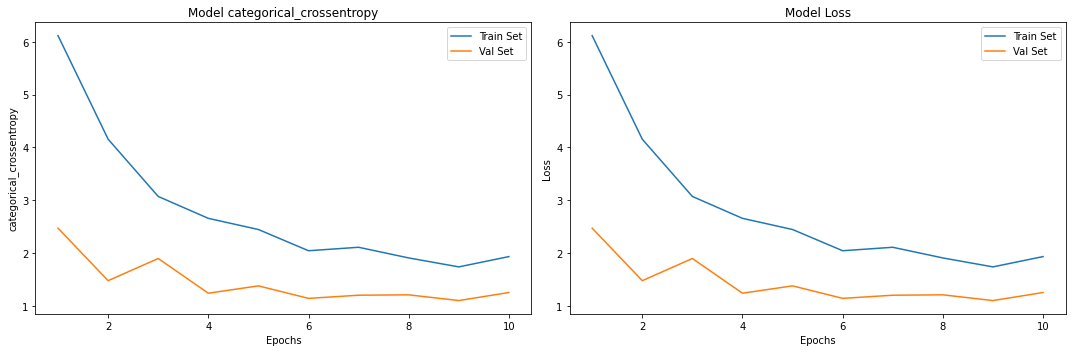

In [37]:
# plot model performance
acc = history.history['categorical_crossentropy']
val_acc = history.history['val_categorical_crossentropy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('categorical_crossentropy')
plt.title('Model categorical_crossentropy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [47]:
# validate on val set
predictions = model.predict(X_val_prep)
import sklearn

confusion_mtx = sklearn.metrics.multilabel_confusion_matrix(y_val, predictions, labels=["glioma", "pituitary", "meningioma", "Norm"]) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

ValueError: ignored

In [0]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [0]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

In [0]:
# save the model
model.save('/content/drive/My Drive/mri/2020-04-02_VGG_model.h5')

In [43]:
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model = load_model('2020-04-02_VGG_model.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning:

Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.



In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

In [0]:
predictions = model.predict(X_val_prep)

In [66]:
predictions

array([[1.0000000e+00, 5.8307533e-21, 1.1044519e-09, 6.3273415e-13],
       [1.0000000e+00, 2.5856741e-21, 5.2938842e-10, 8.5844655e-18],
       [1.0000000e+00, 4.0558437e-36, 2.9039262e-21, 1.6042037e-19],
       ...,
       [0.0000000e+00, 6.5058206e-35, 0.0000000e+00, 1.0000000e+00],
       [1.6489733e-37, 1.2212900e-18, 2.1457121e-19, 1.0000000e+00],
       [0.0000000e+00, 1.4785132e-30, 0.0000000e+00, 1.0000000e+00]],
      dtype=float32)

In [69]:
from sklearn.metrics import classification_report
target_names=["glioma", "pituitary", "meningioma", "Norm"]
print(classification_report(X_val_prep, predictions, target_names=target_names))
print(confusion_matrix(X_test, predictions, labels=target_names))

ValueError: ignored

In [58]:
class_names = ["glioma", "pituitary", "meningioma", "Norm"]

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svm, predictions, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

ValueError: ignored